Loads the QuickDraw dataset. Demonstrates reading the original files, working with the data as a sequence of strokes, and converting those strokes to images. Also writes a dataset to disk in a convenient format.

In [1]:
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import functools, itertools, json, os, re, textwrap
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

# Get the data

In [2]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [3]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
    os.mkdir(data_path)

# Even larger group of all animals.
animals = ['bird', 'butterfly', 'cat', 'crab', 'dolphin', 'elephant', 'fish',
           'giraffe', 'horse', 'lobster', 'penguin', 'rabbit',
           'spider', 'squirrel', 'whale']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of the above groups.
# Note: This will result in ~100MB of download per class.
classes, classes_name = animals, 'animals'

In [4]:
# Download the chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')



15 classes:
bird 65.86 MB
butterfly 63.27 MB
cat 73.12 MB
crab 76.46 MB
dolphin 46.29 MB
elephant 70.86 MB
fish 48.59 MB
giraffe 58.27 MB
horse 99.79 MB
lobster 86.65 MB
penguin 137.90 MB
rabbit 95.05 MB
spider 115.32 MB
squirrel 100.65 MB
whale 53.94 MB

DONE :)


# Inspect the data

In [5]:
# So let's check out the downloaded files...
!ls -lh $data_path

total 3.3G
-rw-rw-r-- 1 veeannzhang veeannzhang  59M Nov  5 04:58 bat.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  66M Nov  5 04:58 bird.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  64M Nov  5 04:58 butterfly.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  55M Nov  5 04:58 camel.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  74M Nov  5 04:58 cat.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  92M Nov  5 04:58 cow.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  77M Nov  5 04:58 crab.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  58M Nov  5 04:58 crocodile.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  88M Nov  5 04:58 dog.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  47M Nov  5 04:58 dolphin.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  68M Nov  5 04:58 duck.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  71M Nov  4 22:28 elephant.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  49M Nov  5 04:58 fish.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang  93M Nov  5 04:58 frog.ndjson
-rw-rw-r-- 1 veeannzhang veeannzhang 

In [6]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
print(open(path).read()[:1000] + '...')

{"word":"bird","countrycode":"US","timestamp":"2017-03-09 00:28:55.63775 UTC","recognized":true,"key_id":"4926006882205696","drawing":[[[0,11,23,50,72,96,97,132,158,224,255],[22,9,2,0,26,45,71,40,27,10,9]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-29 04:22:58.82297 UTC","recognized":true,"key_id":"5357674197680128","drawing":[[[65,194,221,240,250,255,251,242,227,210,173,154,133,86,58,55],[102,104,111,120,130,151,161,173,181,184,186,181,170,138,106,94]],[[211,216],[133,138]],[[208,205,205],[154,164,159]],[[94,82,74,74,83,91,106,139,164],[143,165,196,244,250,250,242,211,146]],[[107,108,111,127,155,175,181,181,176,178],[84,53,44,20,2,0,16,52,79,92]],[[42,25,3,0],[94,89,62,39]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-17 19:31:28.87981 UTC","recognized":true,"key_id":"5553672849195008","drawing":[[[159,163,175,189,201,209,227,245,253,255],[15,9,2,0,5,16,8,7,15,23]],[[124,108,101,97,96,105,152,159,171,178,179,168,154,140,125],[52,50,55,63,81,93,115,114,101,73,

In [7]:
# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()

dict_keys(['word', 'countrycode', 'timestamp', 'recognized', 'drawing', 'key_id'])

In [8]:
# So we have some meta information...
for k, v in data_json.items():
    if k != 'drawing':
        print('%20s   ->   %s' % (k, v))

                word   ->   bird
         countrycode   ->   US
           timestamp   ->   2017-03-09 00:28:55.63775 UTC
          recognized   ->   True
              key_id   ->   4926006882205696


In [9]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 11)]

In [10]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
    # Use a different color for each stroke
    colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
    plt.axis('off')
    for stroke, c in zip(drawing, colors):
        #print(stroke[0], stroke[1])
        plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
draw_strokes(drawing)

In [11]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % classes[0])
sample = loadn(classes[0], 100)

loading some "bird"...


In [12]:
sample[0]

{'countrycode': 'US',
 'drawing': [array([[  0,  11,  23,  50,  72,  96,  97, 132, 158, 224, 255],
         [ 22,   9,   2,   0,  26,  45,  71,  40,  27,  10,   9]])],
 'key_id': '4926006882205696',
 'recognized': True,
 'timestamp': '2017-03-09 00:28:55.63775 UTC',
 'word': 'bird'}

In [13]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)
        
# Elephants!

In [14]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

bird 133572 recognized 111611
butterfly 117999 recognized 114549
cat 123202 recognized 103031
crab 126930 recognized 106466
dolphin 121613 recognized 110335
elephant 126969 recognized 104986
fish 134150 recognized 126420
giraffe 127182 recognized 122396
horse 178286 recognized 156302
lobster 140175 recognized 118228
penguin 253791 recognized 231826
rabbit 155288 recognized 133323
spider 209447 recognized 187865
squirrel 156883 recognized 134923
whale 116502 recognized 109081


# Strokes -> Pictures

In [15]:
# The sequence information is important! But... for now we'll 
# convert these sequences to plain old images.

In [16]:

def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

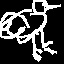

In [17]:
json_to_img(drawing)

In [18]:
# Fetch some images + shuffle order.
n_per_class = 5000
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
draw_strokes(drawings_list[0]['drawing'])
print(str(drawings_list[0]['word']))

cat


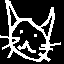

In [19]:
json_to_img(drawings_list[0]['drawing'])

# Save a dataset to disk

In [20]:
X, y = [], []
for drawing in drawings_list:
    X.append(np.array(json_to_img(drawing['drawing'])))
    y.append(str(drawing['word']))
    
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'wb')
np.savez_compressed(out, X, y, X=X, y=y)

In [21]:
# Demonstrate loading
loaded = np.load(open(dataset_path, 'rb'))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)

(75000, 64, 64) (75000,)


In [22]:
plt.imshow(X[0])
print(y[0])

cat


# ADL HW 3

## 1. Build a CNN-based Classifier 

In [23]:
from keras import layers
from keras import models
from keras import optimizers
from sklearn import preprocessing
import collections
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.


### Transform y values to numbers

In [24]:
label = preprocessing.LabelEncoder()
label.fit(animals)

LabelEncoder()

In [25]:
cnt = collections.Counter(y)
y_label = label.transform(y)
print(cnt)

Counter({'giraffe': 5000, 'horse': 5000, 'crab': 5000, 'penguin': 5000, 'butterfly': 5000, 'dolphin': 5000, 'rabbit': 5000, 'fish': 5000, 'whale': 5000, 'elephant': 5000, 'squirrel': 5000, 'lobster': 5000, 'cat': 5000, 'spider': 5000, 'bird': 5000})


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label)

In [27]:
X_train.shape

(56250, 64, 64)

In [28]:
X_test.shape

(18750, 64, 64)

In [29]:
X_train = X_train.reshape((56250, 64, 64, 1))
X_test = X_test.reshape((18750, 64, 64, 1))

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation = 'softmax'))

In [31]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [32]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 201s 4ms/step - loss: 4.7895 - acc: 0.4642 - val_loss: 0.8048 - val_acc: 0.7437
Epoch 2/5
45000/45000 [==============================] - 201s 4ms/step - loss: 0.7802 - acc: 0.7556 - val_loss: 0.6633 - val_acc: 0.7867
Epoch 3/5
45000/45000 [==============================] - 200s 4ms/step - loss: 0.5796 - acc: 0.8146 - val_loss: 0.5637 - val_acc: 0.8193
Epoch 4/5
45000/45000 [==============================] - 200s 4ms/step - loss: 0.4686 - acc: 0.8490 - val_loss: 0.5531 - val_acc: 0.8300
Epoch 5/5
45000/45000 [==============================] - 199s 4ms/step - loss: 0.3977 - acc: 0.8724 - val_loss: 0.5355 - val_acc: 0.8387


In [33]:
model.evaluate(X_test, y_test)

18750/18750 [==============================] - 25s 1ms/step


[0.5464620793088277, 0.8356266666857401]

### Design and run experients to compare

#### a) Different learning rates

#### learning rate = 0.01

In [34]:
model_001 = models.Sequential()
model_001.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_001.add(layers.MaxPool2D(2,2))
model_001.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_001.add(layers.MaxPool2D(2,2))
model_001.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_001.add(layers.MaxPool2D(2,2))
model_001.add(layers.Flatten())
model_001.add(layers.Dropout(0.2))
model_001.add(layers.Dense(256, activation = 'relu'))
model_001.add(layers.Dropout(0.2))
model_001.add(layers.Dense(15, activation = 'softmax'))

In [35]:
model_001.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 0.01), metrics = ['acc'])
model_001.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
__________

In [36]:
history = model_001.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 200s 4ms/step - loss: 15.0338 - acc: 0.0672 - val_loss: 15.0622 - val_acc: 0.0655
Epoch 2/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0389 - acc: 0.0670 - val_loss: 15.0622 - val_acc: 0.0655
Epoch 3/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0389 - acc: 0.0670 - val_loss: 15.0622 - val_acc: 0.0655
Epoch 4/5
45000/45000 [==============================] - 200s 4ms/step - loss: 15.0389 - acc: 0.0670 - val_loss: 15.0622 - val_acc: 0.0655
Epoch 5/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0389 - acc: 0.0670 - val_loss: 15.0622 - val_acc: 0.0655


In [37]:
model_001.evaluate(X_test, y_test)

18750/18750 [==============================] - 25s 1ms/step


[15.04355737467448, 0.06666666667461395]

#### learning rate = 0.005

In [38]:
model_0005 = models.Sequential()
model_0005.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_0005.add(layers.MaxPool2D(2,2))
model_0005.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_0005.add(layers.MaxPool2D(2,2))
model_0005.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_0005.add(layers.MaxPool2D(2,2))
model_0005.add(layers.Flatten())
model_0005.add(layers.Dropout(0.2))
model_0005.add(layers.Dense(256, activation = 'relu'))
model_0005.add(layers.Dropout(0.2))
model_0005.add(layers.Dense(15, activation = 'softmax'))

In [39]:
model_0005.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 0.005), metrics = ['acc'])
model_0005.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
__________

In [40]:
history = model_0005.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 200s 4ms/step - loss: 15.0265 - acc: 0.0677 - val_loss: 15.0421 - val_acc: 0.0668
Epoch 2/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0296 - acc: 0.0675 - val_loss: 15.0421 - val_acc: 0.0668
Epoch 3/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0296 - acc: 0.0675 - val_loss: 15.0421 - val_acc: 0.0668
Epoch 4/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0296 - acc: 0.0675 - val_loss: 15.0421 - val_acc: 0.0668
Epoch 5/5
45000/45000 [==============================] - 199s 4ms/step - loss: 15.0296 - acc: 0.0675 - val_loss: 15.0421 - val_acc: 0.0668


In [41]:
model_0005.evaluate(X_test, y_test)

18750/18750 [==============================] - 25s 1ms/step


[15.0779425982666, 0.06453333333333333]

#### b) Different gradient descent optimizers

#### Adagrad optimizer （with learning rate = 0.001)

In [42]:
model_Adagrad = models.Sequential()
model_Adagrad.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_Adagrad.add(layers.MaxPool2D(2,2))
model_Adagrad.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_Adagrad.add(layers.MaxPool2D(2,2))
model_Adagrad.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_Adagrad.add(layers.MaxPool2D(2,2))
model_Adagrad.add(layers.Flatten())
model_Adagrad.add(layers.Dropout(0.2))
model_Adagrad.add(layers.Dense(256, activation = 'relu'))
model_Adagrad.add(layers.Dropout(0.2))
model_Adagrad.add(layers.Dense(15, activation = 'softmax'))

In [43]:
model_Adagrad.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.Adagrad(lr = 0.001), metrics = ['acc'])
model_Adagrad.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
__________

In [44]:
history = model_Adagrad.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 197s 4ms/step - loss: 15.0294 - acc: 0.0675 - val_loss: 15.0607 - val_acc: 0.0656
Epoch 2/5
45000/45000 [==============================] - 196s 4ms/step - loss: 15.0303 - acc: 0.0675 - val_loss: 15.0607 - val_acc: 0.0656
Epoch 3/5
45000/45000 [==============================] - 196s 4ms/step - loss: 15.0303 - acc: 0.0675 - val_loss: 15.0607 - val_acc: 0.0656
Epoch 4/5
45000/45000 [==============================] - 196s 4ms/step - loss: 15.0303 - acc: 0.0675 - val_loss: 15.0607 - val_acc: 0.0656
Epoch 5/5
45000/45000 [==============================] - 195s 4ms/step - loss: 15.0303 - acc: 0.0675 - val_loss: 15.0607 - val_acc: 0.0656


In [45]:
model_Adagrad.evaluate(X_test, y_test)

18750/18750 [==============================] - 24s 1ms/step


[15.064337696736654, 0.06533333333611488]

#### Adam optimizer (with learning rate  = 0.001)

In [46]:
model_Adam = models.Sequential()
model_Adam.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_Adam.add(layers.MaxPool2D(2,2))
model_Adam.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_Adam.add(layers.MaxPool2D(2,2))
model_Adam.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_Adam.add(layers.MaxPool2D(2,2))
model_Adam.add(layers.Flatten())
model_Adam.add(layers.Dropout(0.2))
model_Adam.add(layers.Dense(256, activation = 'relu'))
model_Adam.add(layers.Dropout(0.2))
model_Adam.add(layers.Dense(15, activation = 'softmax'))

In [47]:
model_Adam.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr = 0.001), metrics = ['acc'])
model_Adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
__________

In [48]:
history = model_Adam.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 202s 4ms/step - loss: 15.0435 - acc: 0.0666 - val_loss: 15.0593 - val_acc: 0.0657
Epoch 2/5
45000/45000 [==============================] - 202s 4ms/step - loss: 15.0439 - acc: 0.0666 - val_loss: 15.0593 - val_acc: 0.0657
Epoch 3/5
45000/45000 [==============================] - 202s 4ms/step - loss: 15.0439 - acc: 0.0666 - val_loss: 15.0593 - val_acc: 0.0657
Epoch 4/5
45000/45000 [==============================] - 203s 5ms/step - loss: 15.0439 - acc: 0.0666 - val_loss: 15.0593 - val_acc: 0.0657
Epoch 5/5
45000/45000 [==============================] - 204s 5ms/step - loss: 15.0439 - acc: 0.0666 - val_loss: 15.0593 - val_acc: 0.0657


In [49]:
model_Adam.evaluate(X_test, y_test)

18750/18750 [==============================] - 25s 1ms/step


[15.033241747843425, 0.06730666666944822]

#### c) Different weight initialization strategies

#### Zeros initializer

In [55]:
model_zeros = models.Sequential()
model_zeros.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_zeros.add(layers.MaxPool2D(2,2))
model_zeros.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_zeros.add(layers.MaxPool2D(2,2))
model_zeros.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_zeros.add(layers.MaxPool2D(2,2))
model_zeros.add(layers.Flatten())
model_zeros.add(layers.Dropout(0.2))
model_zeros.add(layers.Dense(256, activation = 'relu', kernel_initializer = 'Zeros'))
model_zeros.add(layers.Dropout(0.2))
model_zeros.add(layers.Dense(15, activation = 'softmax'))

In [56]:
model_zeros.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['acc'])
model_zeros.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
__________

In [57]:
history = model_zeros.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 198s 4ms/step - loss: 2.7081 - acc: 0.0656 - val_loss: 2.7081 - val_acc: 0.0668
Epoch 2/5
45000/45000 [==============================] - 198s 4ms/step - loss: 2.7080 - acc: 0.0675 - val_loss: 2.7082 - val_acc: 0.0628
Epoch 3/5
45000/45000 [==============================] - 198s 4ms/step - loss: 2.7080 - acc: 0.0676 - val_loss: 2.7082 - val_acc: 0.0628
Epoch 4/5
45000/45000 [==============================] - 198s 4ms/step - loss: 2.7080 - acc: 0.0686 - val_loss: 2.7083 - val_acc: 0.0628
Epoch 5/5
45000/45000 [==============================] - 197s 4ms/step - loss: 2.7080 - acc: 0.0686 - val_loss: 2.7083 - val_acc: 0.0628


In [58]:
model_zeros.evaluate(X_test, y_test)

18750/18750 [==============================] - 24s 1ms/step


[2.7082658289082846, 0.06442666667222977]

#### Random Normal initializer

In [59]:
model_rn = models.Sequential()
model_rn.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (64, 64, 1), padding = 'same'))
model_rn.add(layers.MaxPool2D(2,2))
model_rn.add(layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model_rn.add(layers.MaxPool2D(2,2))
model_rn.add(layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model_rn.add(layers.MaxPool2D(2,2))
model_rn.add(layers.Flatten())
model_rn.add(layers.Dropout(0.2))
model_rn.add(layers.Dense(256, activation = 'relu', 
                kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
model_rn.add(layers.Dropout(0.2))
model_rn.add(layers.Dense(15, activation = 'softmax'))

In [60]:
model_rn.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['acc'])
model_rn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
__________

In [61]:
history = model_rn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 45000 samples, validate on 11250 samples
Epoch 1/5
45000/45000 [==============================] - 199s 4ms/step - loss: 13.9444 - acc: 0.1312 - val_loss: 12.9346 - val_acc: 0.1922
Epoch 2/5
45000/45000 [==============================] - 198s 4ms/step - loss: 12.8965 - acc: 0.1928 - val_loss: 11.4264 - val_acc: 0.2769
Epoch 3/5
45000/45000 [==============================] - 197s 4ms/step - loss: 10.3961 - acc: 0.3361 - val_loss: 8.1204 - val_acc: 0.4582
Epoch 4/5
45000/45000 [==============================] - 197s 4ms/step - loss: 4.2353 - acc: 0.4975 - val_loss: 1.1721 - val_acc: 0.6452
Epoch 5/5
45000/45000 [==============================] - 197s 4ms/step - loss: 1.1647 - acc: 0.6496 - val_loss: 0.8895 - val_acc: 0.7207


In [62]:
model_rn.evaluate(X_test, y_test)

18750/18750 [==============================] - 24s 1ms/step


[0.8960831544812521, 0.7182399999745687]

### Evaluation

As we can see from the above models, changing learning rate, gradient descent optimizer, or weight initialization strategies won't help with model performance.


Therefore, our best score comes from the first model: 

Loss score: 0.55

Test score: 0.84